In [7]:
import numpy as np
import pandas as pd 
from sklearn import metrics
import math
import warnings
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
warnings.filterwarnings("ignore")

In [8]:
def getfeature(train):
    df = train.copy()
    df1 = pd.DataFrame()
    
    df1['index'] = df['index']
    
    df['team1_avg_kills']=df[["player1_kills", "player2_kills","player3_kills","player4_kills","player5_kills"]].mean(axis=1)
    df['team2_avg_kills']=df[["player6_kills", "player7_kills","player8_kills","player9_kills","player10_kills"]].mean(axis=1)
    df1['sum_kills']=(df['team1_avg_kills']+df['team2_avg_kills'])
    
    df['team1_avg_assists']=df[["player1_assists", "player2_assists","player3_assists","player4_assists","player5_assists"]].mean(axis=1)
    df['team2_avg_assists']=df[["player6_assists", "player7_assists","player8_assists","player9_assists","player10_assists"]].mean(axis=1)
    df1['sum_assists']=(df['team1_avg_assists']+df['team2_avg_assists'])
    
    df['team1_avg_deaths']=df[["player1_deaths", "player2_deaths","player3_deaths","player4_deaths","player5_deaths"]].mean(axis=1)
    df['team2_avg_deaths']=df[["player6_deaths", "player7_deaths","player8_deaths","player9_deaths","player10_deaths"]].mean(axis=1)
    df1['sum_deaths']=(df['team1_avg_deaths']+df['team2_avg_deaths'])
    
    df['team1_sum_gold']=df[["player1_goldEarned", "player2_goldEarned","player3_goldEarned","player4_goldEarned","player5_goldEarned"]].sum(axis=1)
    df['team2_sum_gold']=df[["player6_goldEarned", "player7_goldEarned","player8_goldEarned","player9_goldEarned","player10_goldEarned"]].sum(axis=1)
    df1['sum_gold']=df['team1_sum_gold']+df['team2_sum_gold']
    return df1

In [9]:
def Normal(train,Min,Max):
    df = train.copy()
    
    df1 = pd.DataFrame()    
    df1['index'] = df['index']
    
    df1['sum_kills'] = (df['sum_kills'] - Min[0])/(Max[0]- Min[0])
    
    df1['sum_assists'] = (df['sum_assists'] - Min[1])/(Max[1]- Min[1])

    df1['sum_deaths'] = (df['sum_deaths'] - Min[2])/(Max[2]- Min[2])
    
    df1['sum_gold'] = (df['sum_gold'] - Min[3])/(Max[3]- Min[3])
    return df1

In [10]:
def roundup(x):
    return int(math.ceil(float(x) / 35)) *35

In [11]:
df1 = pd.read_csv('exp3.csv')
df2 = pd.read_csv('label.csv')

df1 = getfeature(df1)
#Min = [min(df1['sum_kills']), min(df1['sum_assists']), min(df1['sum_deaths']),min(df1['sum_gold']),min(df2['gameDuration'])]
#Max = [max(df1['sum_kills']), max(df1['sum_assists']), max(df1['sum_deaths']),max(df1['sum_gold']),max(df2['gameDuration'])]
#df1 = Normal(df1,Min,Max)

Test = df1[0:20000]
Test = Test.drop(['index'],axis=1)

df = pd.merge(df1[20000:80000], df2,how='left')

#随机打乱
df=df.reindex(np.random.permutation(df.index))

#df[0:48000]['gameDuration'] = df['gameDuration'][0:48000].apply(roundup)
#df['gameDuration'] = (df['gameDuration'] - Min[4])/(Max[4]- Min[4])
df = df.drop(['index'],axis=1)


In [12]:
#初始化
dataset=np.array(df[0:48000])
m,n=np.shape(dataset)
totalX=np.zeros((m,4))
totalY=np.zeros((m,1))
for i in range(m):#分组：前4个值输入
    totalX[i][0]=dataset[i][0]
    totalX[i][1]=dataset[i][1]
    totalX[i][2]=dataset[i][2]
    totalX[i][3]=dataset[i][3]
    totalY[i][0]=dataset[i][4]

data = totalX
labels = totalY 

#测试
test = np.array(df[48000:60000])
m,n=np.shape(test)
testX=np.zeros((m,4))
testY=np.zeros((m,1))
for i in range(m):#分组：前4个值输入
    testX[i][0]=test[i][0]
    testX[i][1]=test[i][1]
    testX[i][2]=test[i][2]
    testX[i][3]=test[i][3]
    testY[i][0]=test[i][4]
#testY = testY*(Max[4] - Min[4])+Min[4]

## BP单层神经网络

In [62]:
##BP神经网络
import tensorflow.compat.v1 as tf
#定义参数
d=4#输入节点个数
l=1#输出节点个数
q=2*d+1#隐层个数,采用经验公式2d+1
eta=0.5#学习率
error=0.0016#精度
 
#初始化权值和阈值
w1= tf.Variable(tf.random.normal([d, q], stddev=1, seed=1))#seed设定随机种子，保证每次初始化相同数据
b1=tf.Variable(tf.constant(0.0,shape=[q]))
w2= tf.Variable(tf.random.normal([q, l], stddev=1, seed=1))
b2=tf.Variable(tf.constant(0.0,shape=[l]))
 
#输入占位
tf.compat.v1.disable_eager_execution()
x = tf.placeholder(tf.float32, shape=(None, d))
y_ = tf.placeholder(tf.float32, shape=(None, l))
 
#构建图：前向传播
a=tf.nn.sigmoid(tf.matmul(x,w1)+b1)#sigmoid激活函数
y=tf.nn.sigmoid(tf.matmul(a,w2)+b2)
mse = tf.reduce_mean(tf.square(y_ -  y))#损失函数采用均方误差
train_step = tf.train.AdamOptimizer(eta).minimize(mse)#Adam算法

data = totalX
labels = totalY 
labels = (labels - Min[4])/(Max[4]- Min[4])

#创建会话来执行图
with tf.Session() as sess:
    init_op = tf.global_variables_initializer()#初始化节点
    sess.run(init_op)
 
    STEPS=0
    while True:
        sess.run(train_step, feed_dict={x: data, y_: labels})
        STEPS+=1
        train_mse= sess.run(mse, feed_dict={x: data, y_: labels})
        if STEPS % 10 == 0:#每训练100次，输出损失函数
            print("第 %d 次训练后,训练集损失函数为：%g" % (STEPS, train_mse))
        if train_mse < error:
            break
    print("总训练次数：",STEPS)

    #测试
    Normal_y= sess.run(y, feed_dict={x: testX})#求得测试集下的y计算值
    DeNormal_y=Normal_y*(Max[4] - Min[4])+Min[4] #将y反归一化
    Dy = DeNormal_y.tolist()
    DY = testY.tolist()
    n = len(Dy)
    right = 0
    
    for i in range(n):
        if Dy[i][0] >= (math.floor(DY[i][0]/100)*100-150) and Dy[i][0] <= (math.ceil(DY[i][0]/100)*100+150):
            right += 1
    print('正确率为：',right/n)
    err_BP = sess.run(mse, feed_dict={y: DeNormal_y, y_: testY})#计算均方误差
    print("测试集均方误差为：",err_BP)
    
    #预测
    test = np.array(Test)    
    y= sess.run(y, feed_dict={x: test})
    y = y*(Max[4] - Min[4])+Min[4] #将y反归一化

第 10 次训练后,训练集损失函数为：0.0110479
第 20 次训练后,训练集损失函数为：0.0239295
第 30 次训练后,训练集损失函数为：0.00918414
第 40 次训练后,训练集损失函数为：0.00875808
第 50 次训练后,训练集损失函数为：0.00764571
第 60 次训练后,训练集损失函数为：0.00665852
第 70 次训练后,训练集损失函数为：0.00619002
第 80 次训练后,训练集损失函数为：0.00575043
第 90 次训练后,训练集损失函数为：0.00523358
第 100 次训练后,训练集损失函数为：0.00459652
第 110 次训练后,训练集损失函数为：0.00382492
第 120 次训练后,训练集损失函数为：0.00302132
第 130 次训练后,训练集损失函数为：0.00243131
第 140 次训练后,训练集损失函数为：0.00216143
第 150 次训练后,训练集损失函数为：0.00208027
第 160 次训练后,训练集损失函数为：0.00204887
第 170 次训练后,训练集损失函数为：0.00203032
第 180 次训练后,训练集损失函数为：0.00202219
第 190 次训练后,训练集损失函数为：0.00201744
第 200 次训练后,训练集损失函数为：0.00201212
第 210 次训练后,训练集损失函数为：0.002006
第 220 次训练后,训练集损失函数为：0.0019989
第 230 次训练后,训练集损失函数为：0.00199055
第 240 次训练后,训练集损失函数为：0.0019808
第 250 次训练后,训练集损失函数为：0.0019695
第 260 次训练后,训练集损失函数为：0.00195657
第 270 次训练后,训练集损失函数为：0.00194195
第 280 次训练后,训练集损失函数为：0.00192564
第 290 次训练后,训练集损失函数为：0.00190769
第 300 次训练后,训练集损失函数为：0.0018882
第 310 次训练后,训练集损失函数为：0.00186733
第 320 次训练后,训练集损失函数为：0.00184528
第 330 次训练后,训练集损失函数为：0.001

In [82]:
df_new = pd.DataFrame(y)
df_new['index']= range(len(df_new))
df_new.columns=['gameDuration','index']
df_new=df_new.reindex(columns=['index','gameDuration'])
df_new.to_csv("test_BP.csv",index=False,sep=',')

## KNN

In [7]:
##KNN
from sklearn import neighbors
data = totalX
labels = totalY 
E = [1000000,0]
err_KNN = [0] * 95
for k in range(5,100):
    knn = neighbors.KNeighborsClassifier(k)
    knn.fit(data, labels)
    y = knn.predict(testX)

    err_KNN[k-5] = metrics.mean_squared_error (y, testY)
    if err_KNN[k-5] < E[0]:
        E[0] = err_KNN[k-5]
        E[1] = k
        Y = y
        
n = len(y)
right = 0
for i in range(n):
    if Y[i] >= (math.floor(testY[i][0]/100)*100-150) and Y[i] <= (math.ceil(testY[i][0]/100)*100+150):
    #if abs(Y[i]-testY[i][0]) <= 100:
        right += 1

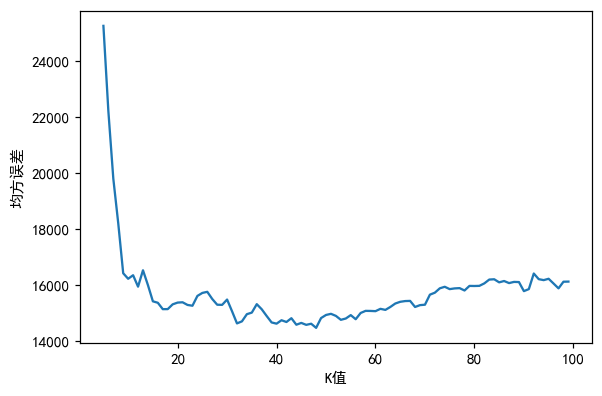

最佳正确率为： 0.9739166666666667
最佳K值为： 48 测试集均方误差为： 14459.062


In [8]:
plt.figure(dpi=110)
plt.xlabel("K值")
plt.ylabel("均方误差")
plt.plot(range(5,100),err_KNN)
plt.show()
print('最佳正确率为：',right/n)
print("最佳K值为：",E[1],"测试集均方误差为：",E[0]);

In [9]:
#预测
knn = neighbors.KNeighborsClassifier(41)
data = totalX
labels = totalY
knn.fit(data, labels)
y = knn.predict(np.array(Test))


In [10]:
df_new = pd.DataFrame(y)
df_new['index']= range(len(df_new))
df_new.columns=['gameDuration','index']
df_new=df_new.reindex(columns=['index','gameDuration'])

In [11]:
df_new.to_csv("test_KNN.csv",index=False,sep=',')

## SVM

In [147]:
#SVM
from sklearn import svm
data = totalX
labels = totalY 
clf = svm.SVR()
clf.fit(totalX, totalY) 
y = clf.predict(testX)
err_svm = metrics.mean_squared_error (y, testY)
print("测试集均方误差为：",err_svm);

测试集均方误差为： 23766.188498855518


## Decision Tree

In [41]:
##tree
from sklearn import tree
data = totalX
labels = totalY 
clf = tree.DecisionTreeRegressor()
clf = clf.fit(data, labels)
y = clf.predict(testX)
err_tree = metrics.mean_squared_error (y, testY)
print("测试集均方误差为：",err_tree);

测试集均方误差为： 24150.702625


In [180]:
#预测
y = clf.predict(np.array(Test))

In [35]:
df_new = pd.DataFrame(y)
df_new['index']= range(len(df_new))
df_new.columns=['gameDuration','index']
df_new=df_new.reindex(columns=['index','gameDuration'])

In [36]:
df_new.to_csv("test_tree.csv",index=False,sep=',')

## Bayes

In [42]:
from sklearn.naive_bayes import GaussianNB
data = totalX
labels = totalY 
gnb = GaussianNB()
gnb = gnb.fit(data, labels)
y = gnb.predict(testX)
err_bayes = metrics.mean_squared_error (y, testY)
print("测试集均方误差为：",err_bayes)

测试集均方误差为： 52772.974916666666


In [37]:
#预测
y = gnb.predict(np.array(Test))

In [38]:
df_new = pd.DataFrame(y)
df_new['index']= range(len(df_new))
df_new.columns=['gameDuration','index']
df_new=df_new.reindex(columns=['index','gameDuration'])

In [39]:
df_new.to_csv("test_bayes.csv",index=False,sep=',')

## 多元

In [35]:
#要重新预处理，时间不预处理（不使用roundup函数）
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

data = totalX
labels = totalY

reg = PolynomialFeatures(degree=4)
data_train = reg.fit_transform(data)
testX_train = reg.fit_transform(testX)
lg = LinearRegression()
lg.fit(data_train,labels)
y = lg.predict(testX_train)
err_ploy = metrics.mean_squared_error (y, testY)
print("测试集均方误差为：",err_ploy)

测试集均方误差为： 12239.60481076169


In [194]:
#预测
Test_train = reg.fit_transform(Test)
y = lg.predict(Test_train)
df_new = pd.DataFrame(y)
df_new['index']= range(len(df_new))
df_new.columns=['gameDuration','index']
df_new=df_new.reindex(columns=['index','gameDuration'])

In [197]:
df_new.to_csv("test_Poly.csv",index=False,sep=',')

## MLP

In [83]:
from sklearn.neural_network import MLPClassifier

data = totalX
labels = totalY

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(9, 4), random_state=1)
clf.fit(data, labels)
y = clf.predict(testX)
err_mlp = metrics.mean_squared_error (y, testY)
print("测试集均方误差为：",err_mlp)

测试集均方误差为： 25560.91075


## Random forest

In [8]:
from sklearn.ensemble import RandomForestClassifier

data = totalX
labels = totalY

clf = RandomForestClassifier(n_jobs=3)
clf.fit(data, labels)
y = clf.predict(testX)
err_for = metrics.mean_squared_error (y, testY)
print("测试集均方误差为：",err_for)

测试集均方误差为： 19525.337083333332


In [85]:
#预测
y = clf.predict(np.array(Test))
df_new = pd.DataFrame(y)
df_new['index']= range(len(df_new))
df_new.columns=['gameDuration','index']
df_new=df_new.reindex(columns=['index','gameDuration'])

In [86]:
df_new.to_csv("test_forest.csv",index=False,sep=',')

## 对比

<BarContainer object of 8 artists>

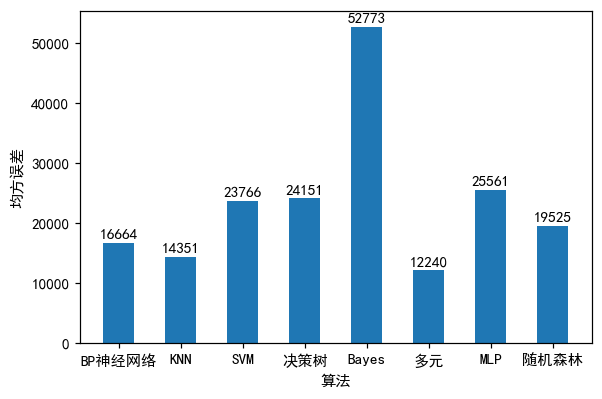

In [84]:
err = [err_BP,E[0],err_svm,err_tree,err_bayes,err_ploy,err_mlp,err_for]
x=['BP神经网络','KNN','SVM','决策树','Bayes','多元','MLP','随机森林']
plt.figure(dpi=110)
plt.xlabel("算法")
plt.ylabel("均方误差")
for a,b in zip(x,err):
    plt.text(a, b+300, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)
x=['BP神经网络','KNN','SVM','决策树','Bayes','多元','MLP','随机森林']
plt.bar(x, height=err, width=0.5, )

## autogluon

In [13]:
#要重新预处理数据，不要将时间整数化（会加大误差），不用归一化
from autogluon.tabular import TabularDataset,TabularPredictor
predictor = TabularPredictor(label='gameDuration').fit(df[0:48000])
a=df[48000:60000].drop(['gameDuration'],axis=1)
y = predictor.predict(a)
err_auto = metrics.mean_squared_error (y, testY)
print("测试集均方误差为：",err_auto);

No path specified. Models will be saved in: "AutogluonModels/ag-20210531_131741\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20210531_131741\"
AutoGluon Version:  0.2.0
Train Data Rows:    48000
Train Data Columns: 4
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (3386, 190, 1626.12452, 450.88851)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2531.29 MB
	Train Data (Original)  Memory Usage: 1.54 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify 

[1000]	train_set's rmse: 108.974	valid_set's rmse: 117.042


	-116.7746	 = Validation root_mean_squared_error score
	5.28s	 = Training runtime
	0.09s	 = Validation runtime
Fitting model: LightGBM ...
	-113.6013	 = Validation root_mean_squared_error score
	0.87s	 = Training runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-118.3523	 = Validation root_mean_squared_error score
	5.13s	 = Training runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ...
	-114.7744	 = Validation root_mean_squared_error score
	3.87s	 = Training runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-119.1727	 = Validation root_mean_squared_error score
	2.1s	 = Training runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-113.6845	 = Validation root_mean_squared_error score
	107.07s	 = Training runtime
	0.1s	 = Validation runtime
Fitting model: XGBoost ...
	-115.1714	 = Validation root_mean_squared_error score
	6.15s	 = Training runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetMXNet ...
	-1

测试集均方误差为： 11266.0005795075


In [ ]:
df_new = pd.DataFrame(y)
df_new['index']= range(len(df_new))
df_new.columns=['gameDuration','index']
df_new=df_new.reindex(columns=['index','gameDuration'])

In [ ]:
df_new.to_csv("test_auto.csv",index=False,sep=',')